# Empirical Risk Minimization and Stochastic Gradient Descent

We want to solve the problem   

$$
    f^* = \text{argmin}_{f \in \mathcal{F}} \mathbb{E}_{x,y}[\ell(f(x), y)].
$$

In general we don't know the probability density function, so we use the empirical approximation

$$
\hat{f} = \text{argmin}_{f \in \mathcal{F}} \underbrace{\frac{1}{N} \sum_{i=1}^{N} \ell(f(x_i), y_i)}_{\text{empirical risk}}
$$

If we parameterize the function as $f(\cdot, \theta)$, we can use the gradient descent update rule

$$
\theta \gets \theta - \frac{\alpha}{N} \sum_{i=1}^{N} \nabla_{\theta} \ell(f(x_i, \theta), y_i)
$$

Stochastic Gradient Descent (SGD) uses only a randomly sampled subset of the data at each step. 

Recall from Recitation 2 that we can take gradients of scalar functions with VJPs. Specifically,

$$
\nabla_{\theta} \ell(f(x,\theta), y) = \frac{\partial f}{\partial \theta}(x, \theta)^\top \nabla_{\hat{y}} \ell(\hat{y}, y).
$$

Deep learning often uses scalar loss functions with many parameters, so VJPs are computationally more efficient that JVPs. For VJPs, recall that we must do a forward pass, store this in memory, and then use this in the backward pass (i.e., backpropagation) for the gradients.

# PyTorch Basics

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

a = torch.tensor(2., requires_grad=True)
b = torch.tensor(1., requires_grad=True)
c = torch.exp(-0.5*a**2 + b)
c.backward(retain_graph=True)
print('a:', a.grad)
print('b:', b.grad)

a: tensor(-0.7358)
b: tensor(0.3679)


In [2]:
c.backward(retain_graph=True)
print('a:', a.grad)
print('b:', b.grad)

a: tensor(-1.4715)
b: tensor(0.7358)


In [3]:
a.grad.zero_()
b.grad.zero_()
c.backward()
print('a:', a.grad)
print('b:', b.grad)

a: tensor(-0.7358)
b: tensor(0.3679)


True parameters:      w = 2.03, b = 1.00
Estimated parameters: w = 2.16, b = 0.98


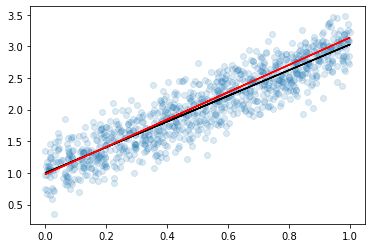

In [4]:
# True parameters
w_true = 2.03
b_true = 1.

# Generate some noisy data
rng = np.random.default_rng(0)  # seed RNG for reproducibility
N = 1000
x = rng.random(N)
y = w_true*x + b_true + 0.25*rng.standard_normal(N)

# Gradient descent on each data point
step_size = 0.1
w = torch.tensor(1., requires_grad=True)
b = torch.tensor(0., requires_grad=True)
for i in range(N):
    y_hat = w*x[i] + b
    loss = (y_hat - y[i])**2
    loss.backward()
    
    # Use this context manager to save memory
    with torch.no_grad():
        w -= step_size*w.grad
        b -= step_size*b.grad
        w.grad.zero_()
        b.grad.zero_()

# Print true and estimated parameters
w_hat = w.item()
b_hat = b.item()
print('True parameters:      w = {:.2f}, b = {:.2f}'.format(w_true, b_true))
print('Estimated parameters: w = {:.2f}, b = {:.2f}'.format(w_hat, b_hat))

# Visualize data fit
plt.scatter(x, y, alpha=0.15)
plt.plot(x, w_true*x + b_true, 'k')
plt.plot(x, w_hat*x + b_hat, 'r')
plt.show()

In [5]:
help(w.item)

Help on built-in function item:

item(...) method of torch.Tensor instance
    item() -> number
    
    Returns the value of this tensor as a standard Python number. This only works
    for tensors with one element. For other cases, see :meth:`~Tensor.tolist`.
    
    This operation is not differentiable.
    
    Example::
    
        >>> x = torch.tensor([1.0])
        >>> x.item()
        1.0



# Training Neural Networks

In [6]:
def f_true(x):
    y = 2./(1. + np.exp(-x**2)) + 0.25*np.cos(x)
    return y


class FeedforwardNetwork(torch.nn.Module):
    def __init__(self, hidden_dims = [32, 32]):
        super().__init__()
        self.f1 = torch.nn.Linear(1, hidden_dims[0])
        self.f2 = torch.nn.Linear(hidden_dims[0], hidden_dims[1])
        self.f3 = torch.nn.Linear(hidden_dims[1], 1)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        h1 = self.activation(self.f1(x))
        h2 = self.activation(self.f2(h1))
        y = self.f3(h2)
        return y


class TrickyFunctionDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples, seed=0):
        super().__init__()
        self.num_samples = num_samples
        self.rng = np.random.default_rng(seed)
        self.x = 10*self.rng.random(num_samples) - 5
        noise = 0.1*self.rng.standard_normal(num_samples)
        self.y = f_true(self.x) + noise
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self,idx):
        return self.x[idx:idx+1], self.y[idx:idx+1]

Epoch 0; Loss = 0.14657436460652265
Epoch 1; Loss = 0.04528165645423177
Epoch 2; Loss = 0.020010147929278792
Epoch 3; Loss = 0.012818287545440305
Epoch 4; Loss = 0.02349702708995808
Epoch 5; Loss = 0.017996355497850367
Epoch 6; Loss = 0.014819131012969427
Epoch 7; Loss = 0.01536259291014217
Epoch 8; Loss = 0.022232038192407787
Epoch 9; Loss = 0.010728698922589507
Epoch 10; Loss = 0.010021701456486128
Epoch 11; Loss = 0.026840050524796315
Epoch 12; Loss = 0.009130275084547283
Epoch 13; Loss = 0.007389969583345741
Epoch 14; Loss = 0.008286372572285773
Epoch 15; Loss = 0.012345784036108042
Epoch 16; Loss = 0.01623163486654398
Epoch 17; Loss = 0.010810654876390937
Epoch 18; Loss = 0.018684064618217585
Epoch 19; Loss = 0.018405596698155443


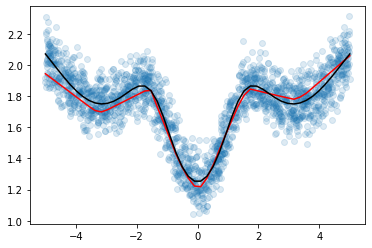

In [7]:
model = FeedforwardNetwork().double()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_samples = 2000
batch_size = 20
num_epochs = 20
dataset = TrickyFunctionDataset(num_samples)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Do gradient descent
for epoch in range(num_epochs):
    for (x,y) in dataloader:        
        y_hat = model(x)
        loss = torch.mean((y_hat - y)**2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Epoch {}; Loss = {}'.format(epoch, loss.item()))
    
# Visualize data fit
x = np.linspace(-5, 5)
y_hat = np.zeros_like(x)
for i, xi in enumerate(x):
    y_hat[i] = model(torch.tensor(xi).reshape((1,))).item()
plt.scatter(dataset.x, dataset.y, alpha=0.15)
plt.plot(x, y_hat, 'r')
plt.plot(x, f_true(x), 'k')
plt.show()